In [ ]:
# aaron elcheson
# sept. 23/2025

# Abstract
We build a material recognition and semantic retrieval pipeline over large texture corpora using **CLIP RN50** embeddings and a **linear head** trained in **Apache Spark**. Images from **MINC-2500** (23 material classes) and **DTD** (47 describable attributes) are embedded into a 1024-D space. A **One-vs-Rest LinearSVC** head trained on MINC achieves **0.7057 accuracy** and **0.7008 weighted-F1** on a held-out split. We also demonstrate **text→image retrieval** by encoding natural-language prompts with CLIP’s text encoder and ranking images by cosine similarity, producing contact sheets for artist support and reference search.

# Data
- **MINC-2500**: ~57.5k material images across 23 classes. Used for **supervised** training/evaluation of the classifier head.  
- **DTD (Describable Textures Dataset)**: ~5.6k images across 47 attribute categories (e.g., *striped, dotted, wrinkled*). Used for **semantic retrieval** demonstrations.  
- Both datasets are stored as **Parquet** with columns `image.bytes`, `image.path`, `label`, plus derived columns: `embedding` (float32[1024]), `sha` (SHA-1 of bytes).  
- Embeddings for both sets are produced with **CLIP RN50** and **L2-normalized** per vector.

# Methods
**Embeddings.** Images are embedded with CLIP RN50 (PyTorch). Each embedding is L2-normalized to stabilize cosine similarity and linear probing.

**Classifier head.** We train a **One-vs-Rest LinearSVC** (hinge loss) in **Spark ML** over MINC embeddings:  
1) Load Parquet into Spark DataFrames.  
2) Convert `embedding: array<float>` to Spark’s `VectorUDT` features.  
3) Deterministic split (80/20).  
4) Fit LinearSVC (`maxIter=200`, `regParam=0.02`).  
5) Evaluate with `MulticlassClassificationEvaluator` (accuracy, weighted-F1).

**Semantic retrieval.** For a text prompt, CLIP’s **text encoder** produces a normalized vector. For each image embedding, relevance is the dot product (cosine similarity). Top-K images are returned and displayed as a contact sheet. Dataset labels are reported **post-hoc** for interpretability only.

**Experiment tracking.** All runs are logged to **MLflow (Machine Learning flow)** with parameters, metrics, artifacts (confusion matrix, contact sheets), and the saved Spark model under a Drive-backed tracking URI.

# Results
- **Linear head (MINC):** accuracy **0.7057**, weighted-F1 **0.7008** on 11,369 validation images; the confusion matrix shows a strong diagonal and symmetric confusions between visually similar materials.  
- **Text→image retrieval (DTD):** prompts such as *“striped, high-contrast fabric”* return images dominated by *striped/banded/lined*, demonstrating attribute-level alignment without using labels during search.

# Reproducibility and Artifacts
- Embedding Parquet files and the trained Spark model are stored in project Drive.  
- MLflow experiment `material_head_rn50` contains runs, metrics, confusion-matrix PNGs, and the `spark_model` artifact.  
- Retrieval grids for both MINC and DTD are saved to Drive and logged to MLflow.

# Limitations
- Linear heads saturate when classes overlap in the embedding space; larger gains require fine-tuning or a shallow nonlinearity.  
- Attribute names may be semantically close (e.g., *striped* vs *banded*), leading to mixed top-K distributions that still match visual intent.

# Usage and Demo Guidance
- **Prompts:** Any natural language is valid; CLIP generalizes beyond dataset label names. If results seem off, broaden or rephrase (e.g., *“coarse stone surface”* instead of *“granite cobblestone alley at dusk”*).  
- **Feedback:** Show top-K previews and simple label histograms so users can judge match quality.  
- **Optional widget:** Provide a prompt box and K selector, plus a toggle for **raw nearest neighbors** vs **class-constrained neighbors** (predict a material with the head, then retrieve within that class). Offer a suggestion list using DTD’s attribute names to set expectations.


In [ ]:
# (1) Mount Drive & set project paths
from google.colab import drive
drive.mount('/content/drive')

from pathlib import Path
import os

ROOT = Path('/content/drive/MyDrive/material_recognizer')
DATA_DIR   = ROOT / 'data'
MINC_PARQ  = DATA_DIR / 'minc2500' / 'parquet'
DTD_PARQ   = DATA_DIR / 'dtd' / 'parquet'
SPARK_OUT  = ROOT / 'spark_out'
MLRUNS_DIR = ROOT / 'mlruns'

for p in (DATA_DIR, MINC_PARQ, DTD_PARQ, SPARK_OUT, MLRUNS_DIR):
    p.mkdir(parents=True, exist_ok=True)

# Persist MLflow runs to Drive (used later during training)
os.environ['MLFLOW_TRACKING_URI'] = f'file://{MLRUNS_DIR}'
print("ROOT:", ROOT)
print("MINC_PARQ exists:", MINC_PARQ.exists())
print("DTD_PARQ  exists:", DTD_PARQ.exists())
print("SPARK_OUT:", SPARK_OUT)


Mounted at /content/drive
ROOT: /content/drive/MyDrive/material_recognizer
MINC_PARQ exists: True
DTD_PARQ  exists: True
SPARK_OUT: /content/drive/MyDrive/material_recognizer/spark_out


In [ ]:
# (2) Install dependencies (single shot; no more pip after this)
!pip -q install pyarrow==17.0.0 pandas==2.2.2 pillow==10.4.0 \
                 torch==2.4.1 torchvision==0.19.1 \
                 open-clip-torch==2.24.0 ftfy==6.2.3 timm==1.0.9 \
                 scikit-learn==1.6.1 xgboost==2.1.1 bokeh==3.7.3 duckdb==1.1.0 mlflow==2.17.2

# quick versions
import importlib, sys
for m in ["pyarrow","pandas","PIL","torch","torchvision","open_clip","sklearn","xgboost","mlflow","duckdb"]:
    mod = importlib.import_module(m if m!="PIL" else "PIL")
    print(f"{m:12s}", getattr(mod,"__version__",""))
print("Python:", sys.version.split()[0])


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 100.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.0/797.0 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 84.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 81.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 82.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 

In [ ]:
# (3) Dataset sanity (counts) — no Spark
import pyarrow.dataset as ds

def count_rows(dirpath):
    d = ds.dataset(str(dirpath))
    # Count using only a lightweight column if present
    return sum(b.num_rows for b in d.to_batches(batch_size=4096))

n_minc = count_rows(MINC_PARQ)
n_dtd  = count_rows(DTD_PARQ)
print(f"MINC rows: {n_minc:,}")
print(f"DTD  rows: {n_dtd:,}")


MINC rows: 57,500
DTD  rows: 5,640


In [ ]:
# (4) Init encoder (RN50, CPU)
import torch, open_clip
USE_GPU = False
MODEL_NAME, PRETRAINED = "RN50", "openai"
device = torch.device("cuda" if (USE_GPU and torch.cuda.is_available()) else "cpu")
model, _, preprocess = open_clip.create_model_and_transforms(MODEL_NAME, pretrained=PRETRAINED, device=device)
model.eval()
ENC_NAME = f"{MODEL_NAME}:{PRETRAINED}"
print("Encoder:", ENC_NAME, "| device:", device.type)


100%|███████████████████████████████████████| 256M/256M [00:05<00:00, 45.9MiB/s]


Encoder: RN50:openai | device: cpu


In [ ]:
# (5) Quick smoke: embed ~256 MINC images (bytes-only), print imgs/sec
import time, io
from PIL import Image
import pyarrow.dataset as ds
import torch, numpy as np

BATCH = 32
scan = ds.dataset(str(MINC_PARQ)).scanner(columns=["image","label"], batch_size=512)
imgs = []
for b in scan.to_batches():
    for bts in b.column("image").field("bytes").to_pylist():
        if bts is None: continue
        try: imgs.append(preprocess(Image.open(io.BytesIO(bts)).convert("RGB")))
        except: pass
        if len(imgs) >= 256: break
    if len(imgs) >= 256: break

t0 = time.time()
with torch.no_grad():
    for i in range(0, len(imgs), BATCH):
        x = torch.stack(imgs[i:i+BATCH])
        e = model.encode_image(x).float()
        _ = torch.nn.functional.normalize(e, dim=1).cpu().numpy()
t1 = time.time()
print(f"processed={len(imgs)}  secs={t1-t0:.2f}  imgs/sec≈{len(imgs)/(t1-t0):.2f}")


processed=256  secs=123.51  imgs/sec≈2.07


In [ ]:
# (6) MINC full embeddings (RN50, CPU) → /material_recognizer/embeddings/emb_minc_rn50.parquet
from pathlib import Path
import io, hashlib
from PIL import Image
import numpy as np
import pyarrow as pa, pyarrow.dataset as ds, pyarrow.parquet as pq
import torch

OUT_DIR  = Path('/content/drive/MyDrive/material_recognizer/embeddings'); OUT_DIR.mkdir(parents=True, exist_ok=True)
OUT_FILE = OUT_DIR/'emb_minc_rn50.parquet'

SCHEMA = pa.schema([
    ("source", pa.string()), ("split", pa.string()), ("label_name", pa.string()),
    ("embedding", pa.list_(pa.float32())), ("dim", pa.int32()),
    ("encoder_name", pa.string()), ("sha", pa.string()),
])

BATCH, LOG_EVERY = 32, 200
writer  = pq.ParquetWriter(str(OUT_FILE), schema=SCHEMA, compression="zstd")
scanner = ds.dataset(str(MINC_PARQ)).scanner(columns=["image","label"], batch_size=2000)

processed = 0
S=[]; P=[]; L=[]; SHA=[]; imgs=[]  # ← initialize lists individually

for batch in scanner.to_batches():
    bytes_list = batch.column("image").field("bytes").to_pylist()
    labels     = batch.column("label").to_pylist()
    for b, lab in zip(bytes_list, labels):
        if b is None: continue
        try:
            im = Image.open(io.BytesIO(b)).convert("RGB")
        except Exception:
            continue
        imgs.append(preprocess(im))
        S.append("minc"); P.append("unknown"); L.append(None if lab is None else str(lab))
        SHA.append(hashlib.sha1(b).hexdigest())

        if len(imgs) == BATCH:
            with torch.no_grad():
                x = torch.stack(imgs)
                e = torch.nn.functional.normalize(model.encode_image(x).float(), dim=1).cpu().numpy().astype("float32")
            dim = int(e.shape[1])
            tbl = pa.Table.from_arrays(
                [pa.array(S), pa.array(P), pa.array(L),
                 pa.array([v.tolist() for v in e], type=pa.list_(pa.float32())),
                 pa.array([dim]*len(S), pa.int32()),
                 pa.array([ENC_NAME]*len(S)), pa.array(SHA)],
                names=["source","split","label_name","embedding","dim","encoder_name","sha"]
            )
            writer.write_table(tbl)
            processed += len(S)
            if processed % LOG_EVERY == 0: print(f"[MINC RN50] {processed}")
            # reset lists individually (no tuple assignment)
            S=[]; P=[]; L=[]; SHA=[]; imgs=[]

# flush remainder
if imgs:
    with torch.no_grad():
        x = torch.stack(imgs)
        e = torch.nn.functional.normalize(model.encode_image(x).float(), dim=1).cpu().numpy().astype("float32")
    dim = int(e.shape[1])
    tbl = pa.Table.from_arrays(
        [pa.array(S), pa.array(P), pa.array(L),
         pa.array([v.tolist() for v in e], type=pa.list_(pa.float32())),
         pa.array([dim]*len(S), pa.int32()),
         pa.array([ENC_NAME]*len(S)), pa.array(SHA)],
        names=["source","split","label_name","embedding","dim","encoder_name","sha"]
    )
    writer.write_table(tbl)
    processed += len(S)

writer.close()
print(f"✓ MINC RN50 → {OUT_FILE} | rows={processed}")


[MINC RN50] 800
[MINC RN50] 1600
[MINC RN50] 2400
[MINC RN50] 3200
[MINC RN50] 4000
[MINC RN50] 4800
[MINC RN50] 5600
[MINC RN50] 6400
[MINC RN50] 7200
[MINC RN50] 8000
[MINC RN50] 8800
[MINC RN50] 9600
[MINC RN50] 10400
[MINC RN50] 11200
[MINC RN50] 12000
[MINC RN50] 12800
[MINC RN50] 13600
[MINC RN50] 14400
[MINC RN50] 15200
[MINC RN50] 16000
[MINC RN50] 16800
[MINC RN50] 17600
[MINC RN50] 18400
[MINC RN50] 19200
[MINC RN50] 20000
[MINC RN50] 20800
[MINC RN50] 21600
[MINC RN50] 22400
[MINC RN50] 23200
[MINC RN50] 24000
[MINC RN50] 24800
[MINC RN50] 25600
[MINC RN50] 26400
[MINC RN50] 27200
[MINC RN50] 28000
[MINC RN50] 28800
[MINC RN50] 29600
[MINC RN50] 30400
[MINC RN50] 31200
[MINC RN50] 32000
[MINC RN50] 32800
[MINC RN50] 33600
[MINC RN50] 34400
[MINC RN50] 35200
[MINC RN50] 36000
[MINC RN50] 36800
[MINC RN50] 37600
[MINC RN50] 38400
[MINC RN50] 39200
[MINC RN50] 40000
[MINC RN50] 40800
[MINC RN50] 41600
[MINC RN50] 42400
[MINC RN50] 43200
[MINC RN50] 44000
[MINC RN50] 44800
[MINC

In [ ]:
# (DTD) full embeddings (RN50, CPU) → /content/drive/MyDrive/material_recognizer/embeddings/emb_dtd_rn50.parquet
from pathlib import Path
import io, hashlib
from PIL import Image
import numpy as np
import pyarrow as pa, pyarrow.dataset as ds, pyarrow.parquet as pq
import torch

# assumes: DTD_PARQ, and RN50 already initialized as: model, preprocess, ENC_NAME
OUT_DIR  = Path('/content/drive/MyDrive/material_recognizer/embeddings')
OUT_FILE = OUT_DIR/'emb_dtd_rn50.parquet'

SCHEMA = pa.schema([
    ("source", pa.string()), ("split", pa.string()), ("label_name", pa.string()),
    ("embedding", pa.list_(pa.float32())), ("dim", pa.int32()),
    ("encoder_name", pa.string()), ("sha", pa.string()),
])

BATCH, LOG_EVERY = 32, 200
writer  = pq.ParquetWriter(str(OUT_FILE), schema=SCHEMA, compression="zstd")
scanner = ds.dataset(str(DTD_PARQ)).scanner(columns=["image","label"], batch_size=2000)

processed = 0
S=[]; P=[]; L=[]; SHA=[]; imgs=[]

for batch in scanner.to_batches():
    bytes_list = batch.column("image").field("bytes").to_pylist()
    labels     = batch.column("label").to_pylist()
    for b, lab in zip(bytes_list, labels):
        if b is None: continue
        try:
            im = Image.open(io.BytesIO(b)).convert("RGB")
        except Exception:
            continue
        imgs.append(preprocess(im))
        S.append("dtd"); P.append("unknown"); L.append(None if lab is None else str(lab))
        SHA.append(hashlib.sha1(b).hexdigest())

        if len(imgs) == BATCH:
            with torch.no_grad():
                x = torch.stack(imgs)
                e = torch.nn.functional.normalize(model.encode_image(x).float(), dim=1).cpu().numpy().astype("float32")
            dim = int(e.shape[1])
            tbl = pa.Table.from_arrays(
                [pa.array(S), pa.array(P), pa.array(L),
                 pa.array([v.tolist() for v in e], type=pa.list_(pa.float32())),
                 pa.array([dim]*len(S), pa.int32()),
                 pa.array([ENC_NAME]*len(S)), pa.array(SHA)],
                names=["source","split","label_name","embedding","dim","encoder_name","sha"]
            )
            writer.write_table(tbl); processed += len(S)
            if processed % LOG_EVERY == 0: print(f"[DTD RN50] {processed}")
            S=[]; P=[]; L=[]; SHA=[]; imgs=[]

# flush remainder
if imgs:
    with torch.no_grad():
        x = torch.stack(imgs)
        e = torch.nn.functional.normalize(model.encode_image(x).float(), dim=1).cpu().numpy().astype("float32")
    dim = int(e.shape[1])
    tbl = pa.Table.from_arrays(
        [pa.array(S), pa.array(P), pa.array(L),
         pa.array([v.tolist() for v in e], type=pa.list_(pa.float32())),
         pa.array([dim]*len(S), pa.int32()),
         pa.array([ENC_NAME]*len(S)), pa.array(SHA)],
        names=["source","split","label_name","embedding","dim","encoder_name","sha"]
    )
    writer.write_table(tbl); processed += len(S)

writer.close()
print(f"✓ DTD RN50 → {OUT_FILE} | rows={processed}")


[DTD RN50] 800
[DTD RN50] 1600
[DTD RN50] 2400
[DTD RN50] 3200
[DTD RN50] 4000
[DTD RN50] 4800
[DTD RN50] 5600
✓ DTD RN50 → /content/drive/MyDrive/material_recognizer/embeddings/emb_dtd_rn50.parquet | rows=5640


In [ ]:
# Install Spark (PySpark) and verify import
!pip -q install "pyspark==3.5.1"

import pyspark, py4j
print("pyspark:", pyspark.__version__, "| py4j:", py4j.__version__)


pyspark: 3.5.1 | py4j: 0.10.9.7


In [ ]:
# Start Spark (local mode) — stable settings for Colab
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
    .master("local[*]")                 # use all CPU cores on this machine
    .appName("material_head_spark")
    .config("spark.driver.host", "127.0.0.1")
    .config("spark.driver.bindAddress", "127.0.0.1")
    .config("spark.sql.execution.arrow.pyspark.enabled", "true")
    .getOrCreate()
)

print("Spark:", spark.version)


Spark: 3.5.1


In [ ]:
# Load MINC embeddings parquet into Spark and inspect
from pathlib import Path

EMB_DIR  = Path('/content/drive/MyDrive/material_recognizer/embeddings')
MINC_EMB = EMB_DIR / 'emb_minc_rn50.parquet'

df = spark.read.parquet(str(MINC_EMB))

print("Rows:", df.count())
df.printSchema()
df.limit(3).show(truncate=False)


Rows: 57500
root
 |-- source: string (nullable = true)
 |-- split: string (nullable = true)
 |-- label_name: string (nullable = true)
 |-- embedding: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- dim: integer (nullable = true)
 |-- encoder_name: string (nullable = true)
 |-- sha: string (nullable = true)

+------+-------+----------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# Prep: numeric label + ML vector features
from pyspark.sql import functions as F
from pyspark.ml.functions import array_to_vector

df_feat = (
    df.select(
        F.col("label_name").cast("int").alias("label"),
        array_to_vector("embedding").alias("features")
    )
    .na.drop(subset=["label","features"])
)

print("Rows (clean):", df_feat.count())
df_feat.printSchema()
df_feat.show(3, truncate=False)


Rows (clean): 57500
root
 |-- label: integer (nullable = true)
 |-- features: vector (nullable = true)

+-----+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# Train/val split (deterministic) + cache
train_df, val_df = df_feat.randomSplit([0.8, 0.2], seed=42)
train_df = train_df.cache(); val_df = val_df.cache()
print("train:", train_df.count(), " | val:", val_df.count())


train: 46131  | val: 11369


In [ ]:
# Train a multinomial Logistic Regression head on MINC embeddings
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(
    featuresCol="features",
    labelCol="label",
    maxIter=100,
    regParam=0.1,          # tweak later if needed
    elasticNetParam=0.0,   # 0=L2, 1=L1
    family="multinomial",  # multi-class softmax
    standardization=True   # Spark standardizes internally
)

model = lr.fit(train_df)
print("Trained multinomial LR. classes:", len(model.summary.labels))


Trained multinomial LR. classes: 23


In [ ]:
# Evaluate on validation set
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

val_pred = model.transform(val_df).select("label", "prediction")

acc = MulticlassClassificationEvaluator(metricName="accuracy").evaluate(val_pred)
f1w = MulticlassClassificationEvaluator(metricName="f1").evaluate(val_pred)  # weighted F1

print(f"val accuracy: {acc:.4f} | weighted F1: {f1w:.4f}")


val accuracy: 0.6936 | weighted F1: 0.6912


In [ ]:
# Diagnostics: biggest confusions + class support
from pyspark.sql import functions as F

val_pred = model.transform(val_df).select("label", "prediction")

print("Top confusions (label -> prediction):")
(val_pred
 .where(F.col("label") != F.col("prediction"))
 .groupBy("label","prediction")
 .count()
 .orderBy(F.desc("count"))
 .show(15))

print("Per-class support in val:")
(val_pred
 .groupBy("label")
 .count()
 .orderBy("label")
 .show(23))


Top confusions (label -> prediction):
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|   16|       7.0|  127|
|    7|      16.0|   91|
|    3|       8.0|   62|
|   13|      14.0|   53|
|    9|      15.0|   52|
|    8|       3.0|   47|
|   15|       9.0|   46|
|    9|      14.0|   42|
|   22|       1.0|   42|
|    6|      10.0|   37|
|    3|      16.0|   37|
|   10|      12.0|   35|
|   11|       3.0|   34|
|    0|      18.0|   33|
|    2|      14.0|   31|
+-----+----------+-----+
only showing top 15 rows

Per-class support in val:
+-----+-----+
|label|count|
+-----+-----+
|    0|  448|
|    1|  515|
|    2|  478|
|    3|  503|
|    4|  497|
|    5|  494|
|    6|  496|
|    7|  511|
|    8|  501|
|    9|  503|
|   10|  480|
|   11|  530|
|   12|  452|
|   13|  516|
|   14|  463|
|   15|  495|
|   16|  504|
|   17|  480|
|   18|  502|
|   19|  507|
|   20|  457|
|   21|  496|
|   22|  541|
+-----+-----+



In [ ]:
# Tiny tune A — multinomial LR with lighter regularization
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

lr2 = LogisticRegression(
    featuresCol="features",
    labelCol="label",
    maxIter=200,
    regParam=0.02,        # was 0.10
    elasticNetParam=0.10, # add mild L1
    family="multinomial",
    standardization=True
)
model2 = lr2.fit(train_df)

val_pred2 = model2.transform(val_df).select("label","prediction")
acc2 = MulticlassClassificationEvaluator(metricName="accuracy").evaluate(val_pred2)
f1w2 = MulticlassClassificationEvaluator(metricName="f1").evaluate(val_pred2)
print(f"[tuned] val accuracy: {acc2:.4f} | weighted F1: {f1w2:.4f}")


[tuned] val accuracy: 0.6885 | weighted F1: 0.6858


In [ ]:
# One-vs-Rest LinearSVC on embeddings
from pyspark.ml.classification import LinearSVC, OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

svc = LinearSVC(featuresCol="features", labelCol="label",
                maxIter=200, regParam=0.02)   # modest C=1/regParam
ovr = OneVsRest(classifier=svc, labelCol="label", featuresCol="features")

ovr_model = ovr.fit(train_df)
val_pred_svc = ovr_model.transform(val_df).select("label","prediction")

acc_svc = MulticlassClassificationEvaluator(metricName="accuracy").evaluate(val_pred_svc)
f1w_svc = MulticlassClassificationEvaluator(metricName="f1").evaluate(val_pred_svc)

print(f"[OvR LinearSVC] val accuracy: {acc_svc:.4f} | weighted F1: {f1w_svc:.4f}")


[OvR LinearSVC] val accuracy: 0.7057 | weighted F1: 0.7008


In [ ]:
# Log best model (OvR LinearSVC) to MLflow
import mlflow, mlflow.spark

mlflow.set_experiment("material_head_rn50")
with mlflow.start_run(run_name="ovr_linearsvc_rn50"):
    mlflow.log_param("encoder", "RN50:openai")
    mlflow.log_param("features_dim", 1024)
    mlflow.log_param("algo", "OneVsRest(LinearSVC)")
    mlflow.log_param("regParam", 0.02)
    mlflow.log_param("maxIter", 200)

    mlflow.log_metric("val_accuracy", float(acc_svc))
    mlflow.log_metric("val_f1_weighted", float(f1w_svc))

    mlflow.spark.log_model(ovr_model, "spark_model")

print("✅ Logged to MLflow. Tracking URI:", mlflow.get_tracking_uri())


2025/09/24 18:10:18 INFO mlflow.tracking.fluent: Experiment with name 'material_head_rn50' does not exist. Creating a new experiment.
2025/09/24 18:11:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Logged to MLflow. Tracking URI: file:///content/drive/MyDrive/material_recognizer/mlruns


In [ ]:
# Create & log a confusion-matrix PNG to the most recent MLflow run
import mlflow
from mlflow.tracking import MlflowClient
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# 1) Materialize preds (uses OvR SVC preds we computed earlier)
pdf = val_pred_svc.toPandas()
labels_sorted = sorted(pdf['label'].unique())
cm = confusion_matrix(pdf['label'], pdf['prediction'], labels=labels_sorted)

# 2) Plot (matplotlib, no special styling)
fig, ax = plt.subplots(figsize=(6,6))
disp = ConfusionMatrixDisplay(cm, display_labels=labels_sorted)
disp.plot(ax=ax, xticks_rotation='vertical', values_format='d')
plt.tight_layout()
png_path = "/content/confusion_matrix.png"
plt.savefig(png_path, dpi=150, bbox_inches='tight')
plt.close(fig)

# 3) Attach to the latest run in the 'material_head_rn50' experiment
client = MlflowClient()
exp = client.get_experiment_by_name("material_head_rn50")
latest_run = client.search_runs(exp.experiment_id, order_by=["attributes.start_time DESC"], max_results=1)[0]
with mlflow.start_run(run_id=latest_run.info.run_id):
    mlflow.log_artifact(png_path, artifact_path="plots")

print("✅ Logged confusion_matrix.png to run:", latest_run.info.run_id)


✅ Logged confusion_matrix.png to run: ceacd99b39bc4ec3bfce36d29470f473


In [ ]:
# R1 — Text→MINC retrieval (single cell, self-contained, no overwrites)
from pathlib import Path
import numpy as np, pyarrow.dataset as ds
import torch, open_clip

# --- settings ---
PROMPT = "brick wall, rough texture"   # ← edit to try other queries
K = 12
EMB_MINC = Path('/content/drive/MyDrive/material_recognizer/embeddings/emb_minc_rn50.parquet')

# --- (re)load CLIP RN50 under distinct names to avoid collisions with Spark models ---
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")
clip_model, _, _clip_preprocess = open_clip.create_model_and_transforms("RN50", pretrained="openai", device=device)
clip_model.eval()

# --- load MINC embeddings (already L2-normalized) ---
tbl = ds.dataset(str(EMB_MINC)).to_table(columns=["embedding","label_name","sha"])
embs   = np.asarray(tbl["embedding"].to_pylist(), dtype=np.float32)  # (N, 1024)
labels = np.array([int(x) if x not in (None, "") else -1 for x in tbl["label_name"].to_pylist()])
shas   = np.array(tbl["sha"].to_pylist())

# --- encode text prompt and L2-normalize ---
with torch.no_grad():
    tok = open_clip.tokenize([PROMPT]).to(device)
    txt = clip_model.encode_text(tok).float()
    txt = torch.nn.functional.normalize(txt, dim=1).cpu().numpy().astype("float32")[0]

# --- cosine similarity (dot product for unit vectors) & top-K ---
sims = embs @ txt
topk_idx = sims.argsort()[-K:][::-1]

print(f"\nQuery: {PROMPT!r}")
print("Top-K label ids:", labels[topk_idx].tolist())
u, c = np.unique(labels[topk_idx], return_counts=True)
print("Top-K label histogram (id:count):", dict(zip(u.tolist(), c.tolist())))
print("Top-K shas:", shas[topk_idx].tolist())



Query: 'brick wall, rough texture'
Top-K label ids: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Top-K label histogram (id:count): {0: 12}
Top-K shas: ['ce43d472e192704f7bd785427328adc776be281d', '36c92b6d5277eefb1a4aa08f61b4f5dffd1214f3', 'efdbe8ef2708b0a35b3e07a44d0fbbce58499d33', 'f5070bffa29f454f4958c16e71cab73f712caff7', '04aee0dee037c392ff1f68b777db7d146691d7f7', '4e7ff78f7bd82ada67f59277f625461cb53927ce', '964076011a33f20f2771801444fa4e8fb6eb34a4', '23faf9f9c9f96d7fc656514f8df9764b4a9cb092', '1a841aa24aa9cfb0eb5e7023ff676ee7d5567ff3', 'dbac3325d242da3dbafbcb302452b86e9dc3b128', '3ffbfb46dd0ae1254b4e4a20f0e0565fcee38521', '57aff0d7a0830cb817531e30487af634c792750b']


In [ ]:
# R2 — Contact sheet of top-K MINC results (uses shas/topk_idx from the previous cell)
from PIL import Image
import io, hashlib, numpy as np
import pyarrow.dataset as ds

# derive the top-K sha list from prior variables
topk_shas = [str(x) for x in shas[topk_idx].tolist()]
need = set(topk_shas)
imgs = []

# stream through MINC_PARQ and collect matching images by sha1(bytes)
dataset = ds.dataset(str(MINC_PARQ))
for batch in dataset.to_batches(batch_size=2000):
    bytes_list = batch.column("image").field("bytes").to_pylist()
    for b in bytes_list:
        if b is None:
            continue
        sha = hashlib.sha1(b).hexdigest()
        if sha in need:
            try:
                imgs.append(Image.open(io.BytesIO(b)).convert("RGB"))
                need.remove(sha)
            except Exception:
                pass
            if not need:
                break
    if not need:
        break

# build a simple grid
cols = 4
thumb = 160
rows_n = int(np.ceil(len(imgs)/cols)) if imgs else 0
grid = Image.new("RGB", (cols*thumb, max(1, rows_n)*thumb), (0,0,0))

for i, im in enumerate(imgs):
    im = im.resize((thumb, thumb))
    r, c = divmod(i, cols)
    grid.paste(im, (c*thumb, r*thumb))

out_path = "/content/minc_topk_grid.png"
grid.save(out_path)
print(f"✓ Saved contact sheet → {out_path}  | images={len(imgs)}  | missing={len(need)}")


✓ Saved contact sheet → /content/minc_topk_grid.png  | images=12  | missing=0


In [ ]:
# R1-DTD — Text→image retrieval on DTD embeddings (print-only)
from pathlib import Path
import numpy as np, pyarrow.dataset as ds
import torch, open_clip

PROMPT = "striped, high-contrast fabric"   # ← try any attribute phrase
K = 12
EMB_DTD = Path('/content/drive/MyDrive/material_recognizer/embeddings/emb_dtd_rn50.parquet')

# (re)load CLIP RN50 under distinct vars
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
clip_model, _, _ = open_clip.create_model_and_transforms("RN50", pretrained="openai", device=device)
clip_model.eval()

# load DTD embeddings
tbl = ds.dataset(str(EMB_DTD)).to_table(columns=["embedding","label_name","sha"])
embs   = np.asarray(tbl["embedding"].to_pylist(), dtype=np.float32)
labels = np.array([int(x) if x not in (None, "") else -1 for x in tbl["label_name"].to_pylist()])
shas   = np.array(tbl["sha"].to_pylist())

# text → vector (L2-normalized)
with torch.no_grad():
    tok = open_clip.tokenize([PROMPT]).to(device)
    txt = clip_model.encode_text(tok).float()
    txt = torch.nn.functional.normalize(txt, dim=1).cpu().numpy().astype("float32")[0]

# cosine sim (dot product) & top-K
sims = embs @ txt
topk_idx = sims.argsort()[-K:][::-1]

print(f"Query: {PROMPT!r}")
print("Top-K label ids:", labels[topk_idx].tolist())
u, c = np.unique(labels[topk_idx], return_counts=True)
print("Top-K label histogram (id:count):", dict(zip(u.tolist(), c.tolist())))
print("Top-K shas:", shas[topk_idx].tolist())


Query: 'striped, high-contrast fabric'
Top-K label ids: [39, 0, 39, 0, 22, 0, 22, 22, 0, 22, 0, 0]
Top-K label histogram (id:count): {0: 6, 22: 4, 39: 2}
Top-K shas: ['c4aff622120891f64be2c368d31e5fda8e56b730', 'd9522607acd2bc03b90ec3b6ec495b7705141a2d', 'f198e1011cc7c7bf5cfa06713661ff09fa36a27a', '5692f9a6e73538c887afa921cb8991fb39fa3197', '7fd92e1f311e83cf91fa40a18e18c28dc80abcdd', '2af739d2b341e14a60f77b9d16bf4f1337f56236', '524114792d51364ffafd8a320555965dadee98dc', 'a002c237f9a6684ae42688809a3c1c3779c2b328', '71fa640d21fb702c7d33b946af5a84266c824658', '27032f6116f5a3066454b0f7174ced038f68d346', '4e9ffdbc49587e025bba6ba5112fe8beff30c710', 'bd20e1d5e3e081d2d5fc684e2b0d7c790c3ff1a7']


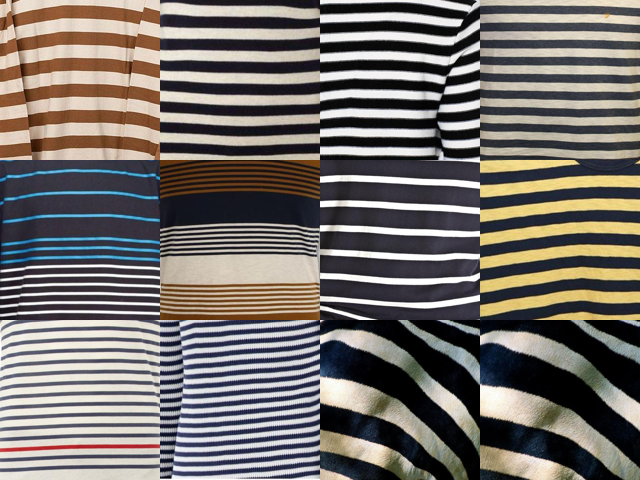

✓ Saved grid → /content/drive/MyDrive/material_recognizer/plots/dtd_topk_grid.png  | images=12  | missing=0
✓ Logged DTD grid to MLflow run: ceacd99b39bc4ec3bfce36d29470f473


In [ ]:
# R2-DTD — Build & save a contact sheet for top-K DTD results; copy to Drive; log to MLflow
from PIL import Image
import io, hashlib, numpy as np
import pyarrow.dataset as ds
from pathlib import Path
from shutil import copy2
from IPython.display import Image as IPyImage, display
import mlflow
from mlflow.tracking import MlflowClient

# 1) Collect images by sha from DTD_PARQ
topk_shas = [str(x) for x in shas[topk_idx].tolist()]
need = set(topk_shas)
imgs = []

dataset = ds.dataset(str(DTD_PARQ))
for batch in dataset.to_batches(batch_size=2000):
    bytes_list = batch.column("image").field("bytes").to_pylist()
    for b in bytes_list:
        if b is None:
            continue
        sha = hashlib.sha1(b).hexdigest()
        if sha in need:
            try:
                imgs.append(Image.open(io.BytesIO(b)).convert("RGB"))
                need.remove(sha)
            except Exception:
                pass
            if not need:
                break
    if not need:
        break

# 2) Make a simple grid
cols, thumb = 4, 160
rows_n = int(np.ceil(len(imgs)/cols)) if imgs else 0
grid = Image.new("RGB", (cols*thumb, max(1, rows_n)*thumb), (0,0,0))
for i, im in enumerate(imgs):
    im = im.resize((thumb, thumb))
    r, c = divmod(i, cols)
    grid.paste(im, (c*thumb, r*thumb))

# 3) Save locally, copy to Drive, display, and log to latest MLflow run
local_png = "/content/dtd_topk_grid.png"
grid.save(local_png)

plots_dir = Path('/content/drive/MyDrive/material_recognizer/plots')
plots_dir.mkdir(parents=True, exist_ok=True)
drive_png = plots_dir / "dtd_topk_grid.png"
copy2(local_png, drive_png)
display(IPyImage(filename=str(drive_png)))
print(f"✓ Saved grid → {drive_png}  | images={len(imgs)}  | missing={len(need)}")

client = MlflowClient()
exp = client.get_experiment_by_name("material_head_rn50")
latest = client.search_runs(exp.experiment_id, order_by=["attributes.start_time DESC"], max_results=1)[0]
with mlflow.start_run(run_id=latest.info.run_id):
    mlflow.log_artifact(str(drive_png), artifact_path="plots")
print("✓ Logged DTD grid to MLflow run:", latest.info.run_id)


In [ ]:
# R1b-DTD — Map DTD label ids → human names from Parquet metadata; print names for last top-K
import json
from collections import Counter
import pyarrow.dataset as ds

# Read label names from the HF metadata embedded in your DTD Parquet
meta = ds.dataset(str(DTD_PARQ)).schema.metadata or {}
names = None
if b'huggingface' in meta:
    try:
        hf = json.loads(meta[b'huggingface'].decode("utf-8"))
        names = hf["info"]["features"]["label"]["names"]  # list of names indexed by id
    except Exception:
        names = None

def id2name(i: int) -> str:
    try:
        i = int(i)
        if names and 0 <= i < len(names):
            return names[i]
    except Exception:
        pass
    return f"label_{i}"

top_ids = labels[topk_idx].tolist()           # from your previous DTD retrieval cell
top_names = [id2name(i) for i in top_ids]

print("Top-K label ids   :", top_ids)
print("Top-K label names :", top_names)
print("Top-K histogram   :", dict(Counter(top_names)))


Top-K label ids   : [39, 0, 39, 0, 22, 0, 22, 22, 0, 22, 0, 0]
Top-K label names : ['striped', 'banded', 'striped', 'banded', 'lined', 'banded', 'lined', 'lined', 'banded', 'lined', 'banded', 'banded']
Top-K histogram   : {'striped': 2, 'banded': 6, 'lined': 4}


In [4]:
# DTD retrieval widget: suggestions + free-text + Top-K → contact sheet (inline)
import json, io, hashlib, numpy as np, pyarrow.dataset as ds
from PIL import Image
from collections import Counter
import ipywidgets as W
from IPython.display import display, Image as IPyImage
import torch, open_clip

# --- paths (uses your existing layout) ---
EMB_DTD  = '/content/drive/MyDrive/material_recognizer/embeddings/emb_dtd_rn50.parquet'
# DTD_PARQ is defined in your first notebook cell

# --- load suggestions from DTD metadata (human names) ---
meta = ds.dataset(str(DTD_PARQ)).schema.metadata or {}
names = []
if b'huggingface' in meta:
    try:
        names = json.loads(meta[b'huggingface'].decode('utf-8'))["info"]["features"]["label"]["names"]
    except Exception:
        names = []
suggest_opts = ['(choose attribute)'] + names

# --- load embeddings to memory (small) ---
tbl    = ds.dataset(EMB_DTD).to_table(columns=["embedding","label_name","sha"])
EMBS   = np.asarray(tbl["embedding"].to_pylist(), dtype=np.float32)        # (N, 1024)
LABELS = np.array([int(x) if x not in (None,"") else -1 for x in tbl["label_name"].to_pylist()])
SHAS   = np.array(tbl["sha"].to_pylist())
IMG_CACHE = {}  # sha -> PIL.Image

# --- CLIP RN50 text encoder (reuse if already present) ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
try:
    _ = clip_model.encode_text  # reuse from earlier if available
except Exception:
    clip_model, _, _ = open_clip.create_model_and_transforms("RN50", pretrained="openai", device=device)
clip_model.eval()

# --- UI ---
dd   = W.Dropdown(options=suggest_opts, description="Suggest:", layout=W.Layout(width="400px"))
txt  = W.Text(value="", placeholder="e.g., striped, high-contrast fabric", description="Prompt:", layout=W.Layout(width="500px"))
k    = W.IntSlider(value=12, min=4, max=24, step=2, description="Top-K:")
btn  = W.Button(description="Search", button_style="primary")
out  = W.Output()

def on_choose(change):
    if change["new"] and change["new"] != "(choose attribute)" and not txt.value:
        txt.value = change["new"]
dd.observe(on_choose, names="value")

def fetch_images_by_sha(target_shas):
    need = set(map(str, target_shas))
    imgs = []
    if not need:
        return imgs
    data = ds.dataset(str(DTD_PARQ))
    for batch in data.to_batches(batch_size=2000):
        bytes_list = batch.column("image").field("bytes").to_pylist()
        for b in bytes_list:
            if b is None:
                continue
            sha = hashlib.sha1(b).hexdigest()
            if sha in need:
                if sha in IMG_CACHE:
                    im = IMG_CACHE[sha]
                else:
                    try:
                        im = Image.open(io.BytesIO(b)).convert("RGB")
                        IMG_CACHE[sha] = im
                    except Exception:
                        continue
                imgs.append(im)
                need.remove(sha)
                if not need:
                    return imgs
    return imgs

def make_grid(images, cols=4, thumb=160):
    rows = max(1, int(np.ceil(len(images)/cols)))
    grid = Image.new("RGB", (cols*thumb, rows*thumb), (40,40,40))
    for i, im in enumerate(images):
        imr = im.resize((thumb, thumb))
        r, c = divmod(i, cols)
        grid.paste(imr, (c*thumb, r*thumb))
    return grid

def on_search(_):
    with out:
        out.clear_output()
        prompt = txt.value.strip() or (dd.value if dd.value != "(choose attribute)" else "texture")
        with torch.no_grad():
            tok = open_clip.tokenize([prompt]).to(device)
            tvec = clip_model.encode_text(tok).float()
            tvec = torch.nn.functional.normalize(tvec, dim=1).cpu().numpy().astype("float32")[0]
        sims = EMBS @ tvec
        idx  = sims.argsort()[-k.value:][::-1]
        sel_labels = LABELS[idx].tolist()
        sel_names  = [names[i] if 0 <= i < len(names) else f"label_{i}" for i in sel_labels]
        sel_shas   = SHAS[idx].tolist()
        # fetch and render
        imgs = fetch_images_by_sha(sel_shas)
        grid = make_grid(imgs)
        buf = io.BytesIO(); grid.save(buf, format="PNG"); buf.seek(0)
        print(f"Query: {prompt!r}")
        print("Top-K histogram:", dict(Counter(sel_names)))
        display(IPyImage(data=buf.getvalue()))

btn.on_click(on_search)

display(W.VBox([W.HBox([dd, txt]), W.HBox([k, btn]), out]))
